# 使用Stable Fluids算法模拟流体运动

参考代码链接：https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/stable_fluids_python_simple.py

youtube链接：https://www.youtube.com/watch?v=wbYe58NGJJI

"""
Solves the incompressible Navier Stokes equations using "Stable Fluids" by Jos Stam
in a closed box with a forcing that creates a bloom. 


`Momentum`: 

$$\underbrace{\frac{\partial \mathbf{u}}{\partial t}}_{\text{I. 非定常项}} + \underbrace{(\mathbf{u} \cdot \nabla) \mathbf{u}}_{\text{II. 对流项}} = \underbrace{- \frac{1}{\rho} \nabla p}_{\text{III. 压力梯度项}} + \underbrace{\nu \nabla^2 \mathbf{u}}_{\text{IV. 粘性项}} + \underbrace{\mathbf{f}}_{\text{V. 体力项}}$$

`Incompressibility`: 

$$\nabla \cdot \mathbf{u} = 0$$


- u:  Velocity (2d vector)
- p:  Pressure
- f:  Forcing
- ν:  Kinematic Viscosity
- ρ:  Density
- t:  Time
- ∇:  Nabla operator (defining nonlinear convection, gradient and divergence)
- ∇²: Laplace Operator


----

A closed box


                                        u = 0
                                        v = 0 

              1 +-------------------------------------------------+
                |                                                 |
                |             *                      *            |
                |          *           *    *    *                |
            0.8 |                                                 |
                |                                 *               |
                |     *       *                                   |
                |                      *     *                    |
            0.6 |                                            *    |
    u = 0       |      *                             *            |   u = 0
    v = 0       |                             *                   |   v = 0
                |                     *                           |
                |           *                *         *          |
            0.4 |                                                 |
                |                                                 |
                |      *            *             *               |
                |           *                             *       |
            0.2 |                       *           *             |
                |                               *                 |
                |  *          *      *                 *       *  |
                |                            *                    |
              0 +-------------------------------------------------+
                0        0.2       0.4       0.6       0.8        1

                                        u = 0
                                        v = 0

* Homogeneous Dirichlet Boundary Condictio

----- 

Forcing Function

          1 +-------------------------------------------------+
            |                                                 |
            |             *                      *            |
            |          *           *    *    *                |
        0.8 |                                                 |
            |                                 *               |
            |     *       *                                   |
            |                      *     *                    |
        0.6 |                                            *    |
            |      *                             *            |
            |                             *                   | 
            |                     *                           |
            |           *                *         *          |
        0.4 |                                                 |
            |                                                 |
            |      *           ^ ^ ^ ^ ^ ^                    |
            |           *      | | | | | |                 *  |
        0.2 |                  | | | | | |     *           *  |
            |                  | | | | | |             *      |
            |  *          *      *                 *       *  |
            |                            *                    |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

-> Upwards pointing force in the lower center of the domain.


-----

Solution Strategy:

$$\mathbf{w}_0(\mathbf{x}) \xrightarrow{\text{add force}} \mathbf{w}_1(\mathbf{x}) \xrightarrow{\text{advect}} \mathbf{w}_2(\mathbf{x}) \xrightarrow{\text{diffuse}} \mathbf{w}_3(\mathbf{x}) \xrightarrow{\text{project}} \mathbf{w}_4(\mathbf{x})$$

-> Start with zero velocity everywhere: u = [0, 0]

1. Add forces

    w₁ = u + Δt f

2. Convect by self-advection (set the value at the current
   location to be the value at the position backtraced
   on the streamline.) -> unconditionally stable

    w₂ = w₁(p(x, −Δt))

3. Diffuse implicitly (Solve a linear system matrix-free
   by Conjugate Gradient) -> unconditionally stable

    (I − ν Δt ∇²)w₃ = w₂

4.1 Compute a pressure correction (Solve a linear system
    matrix-free by Conjugate gradient)

    ∇² p = ∇ ⋅ w₃

4.2 Correct velocities to be incompressible

    w₄ = w₃ − ∇p

5. Advance to next time step

    u = w₄ 


-> The Boundary Conditions are prescribed indirectly using
   the discrete differential operators.

-----

The solver is unconditionally stable, hence all parameters can be
chosen arbitrarily. Still, be careful that too high timesteps can
make the advection step highly incorrect.
"""

## 算符小结（2-D 均匀网格，步长 $h$）

| 算符 | 连续定义 | 离散模板（中心差分） | 输入 → 输出 |
|---|---|---|---|
| **梯度** $\nabla$ | $\begin{bmatrix}\dfrac{\partial f}{\partial x}\\[6pt]\dfrac{\partial f}{\partial y}\end{bmatrix}$ | $\begin{aligned}\partial_x f\vert_{i,j} &= \dfrac{f_{i+1,j}-f_{i-1,j}}{2h}\\[6pt]\partial_y f\vert_{i,j} &= \dfrac{f_{i,j+1}-f_{i,j-1}}{2h}\end{aligned}$ | 标量场 $\rightarrow$ 矢量场 |
| **散度** $\nabla\cdot$ | $\dfrac{\partial u}{\partial x}+\dfrac{\partial v}{\partial y}$ | $(\nabla\!\cdot\boldsymbol{v})_{i,j}= \dfrac{u_{i+1,j}-u_{i-1,j}}{2h}+\dfrac{v_{i,j+1}-v_{i,j-1}}{2h}$ | 矢量场 $\rightarrow$ 标量场 |
| **拉普拉斯** $\nabla^2$ | $\dfrac{\partial^2 f}{\partial x^2}+\dfrac{\partial^2 f}{\partial y^2}$ | $(\nabla^2\!f)_{i,j}= \dfrac{f_{i+1,j}+f_{i-1,j}+f_{i,j+1}+f_{i,j-1}-4f_{i,j}}{h^2}$ | 标量场 $\rightarrow$ 标量场 |


> 对矢量场逐分量调用 $\nabla^2$ 即可。

三者具有以下关系：

$$\nabla \cdot (\nabla q) = \nabla^2 q$$

**证明**

对任意标量场 $q(x,y,z)$，其梯度为：$$\nabla q = \left( \frac{\partial q}{\partial x}, \frac{\partial q}{\partial y}, \frac{\partial q}{\partial z} \right)$$再对这个向量场取散度：$$\nabla \cdot (\nabla q) = \frac{\partial}{\partial x}\left(\frac{\partial q}{\partial x}\right) + \frac{\partial}{\partial y}\left(\frac{\partial q}{\partial y}\right) + \frac{\partial}{\partial z}\left(\frac{\partial q}{\partial z}\right)$$整理后就是熟悉的拉普拉斯算子：$$\nabla^2 q = \frac{\partial^2 q}{\partial x^2} + \frac{\partial^2 q}{\partial y^2} + \frac{\partial^2 q}{\partial z^2}$$因此：$$\boxed{\nabla \cdot (\nabla q) = \nabla^2 q}$$



-----

## 关于共轭梯度法 (Conjugate Gradient, CG)

共轭梯度法是一种**迭代求解器 (Iterative Solver)**，用于求解以下形式的线性方程组：

$$\mathbf{A}\mathbf{x} = \mathbf{b}$$

其中：

  * $\mathbf{A}$ 是一个已知的系数矩阵。
  * $\mathbf{b}$ 是一个已知的右侧项向量。
  * $\mathbf{x}$ 是我们要求的解向量（例如，扩散后的速度 $\mathbf{w}_3$ 或压力场 $q$）。

> **前提条件：** CG 法只能用于求解 $\mathbf{A}$ 是**对称正定 (Symmetric Positive Definite, SPD)** 矩阵的方程组。

-----

### 核心优势：通过算子求解（矩阵无关）

CG 方法在大型科学计算中被称为**矩阵无关 (Matrix-Free)** 方法。

CG 算法在整个迭代过程中，**唯一**需要使用矩阵 $\mathbf{A}$ 的操作是计算**矩阵-向量乘积**：
$$\mathbf{y} = \mathbf{A}\mathbf{p}$$

算法流程中没有涉及到矩阵 $\mathbf{A}$ 的显式存储或反演（即计算 $\mathbf{A}^{-1}$）。

#### 以泊松方程为例：

对于**泊松方程**来说：$$\nabla^2 q = \nabla \cdot \mathbf{w}_3$$

这里面就是方程组 $\mathbf{A}\mathbf{x} = \mathbf{b}$，其中 $\mathbf{A}$ 就是拉普拉斯算子，$\mathbf{b}$ 就是扩散后的速度场 $\mathbf{w}_3$ 的散度场。

这个矩阵 $\mathbf{A}$ 是客观存在的。它是一个巨大的、稀疏的矩阵，定义了网格点上的值如何通过有限差分公式相互连接。

对于向量 $\mathbf{x}$ 中的任何一个元素 $x_k$（对应 $p_{i, j}$），矩阵 $\mathbf{A}$ 的第 $k$ 行将有 5 个非零元素：

  * 中心点 $p_{i, j}$ 对应的列：值是 $-\frac{4}{\Delta x^2}$。
  * 四个邻居 $p_{i \pm 1, j}, p_{i, j \pm 1}$ 对应的列：值是 $\frac{1}{\Delta x^2}$。
  * 其他所有元素都是 $0$。

显式存储几乎是不可能的。

**CG 方法的精髓所在是：它实现了“矩阵无关”求解：**

我们求解 $\mathbf{A}\mathbf{x} = \mathbf{b}$ 时，CG 算法在每一步迭代中，只需要知道如何计算矩阵乘积 $\mathbf{y} = \mathbf{A}\mathbf{p}$。

-----

### Scipy 中 CG 方法的使用

**1. 定义算子函数 (`matvec`)**

您定义了算子函数，例如：

  * `poisson_operator(field_flattened)`: 实现 $\mathbf{A}_{\text{Poisson}} \mathbf{x} = \nabla^2 \mathbf{x}$。

**2. 创建线性算子 (`LinearOperator`)**

```python
A_poisson = splinalg.LinearOperator(
    shape=(scalar_dof, scalar_dof), # 告诉求解器矩阵的维度
    matvec=poisson_operator,       # 传入实现 A * x 运算的函数
)
```

**3. 调用共轭梯度法 (`cg`)**

`splinalg.cg()` 函数用于求解：

```python
# 求解 A_poisson * pressure = divergence(velocities_diffused)
pressure_solution = splinalg.cg(
    A=A_poisson,
    b=divergence(velocities_diffused).flatten(), # b 向量
    maxiter=MAX_ITER_CG, # 最大迭代次数
)

# pressure_solution[0] 是解向量 x
pressure = pressure_solution[0].reshape(scalar_shape) # 将解向量 x 转换回二维数组
```

---
# 公式步骤推导

梳理 Jos Stam 论文中用于流体模拟的两个关键求解步骤：**扩散 (Diffusion)** 和 **投射 (Projection)**。

流体运动由纳维-斯托克斯方程（Navier-Stokes Equations, NSE）描述：

$$\underbrace{\frac{\partial \mathbf{u}}{\partial t}}_{\text{I. 非定常项}} + \underbrace{(\mathbf{u} \cdot \nabla) \mathbf{u}}_{\text{II. 对流项}} = \underbrace{- \frac{1}{\rho} \nabla p}_{\text{III. 压力梯度项}} + \underbrace{\nu \nabla^2 \mathbf{u}}_{\text{IV. 粘性项}} + \underbrace{\mathbf{f}}_{\text{V. 体力项}}$$

Stable Fluids 算法采用**算子分裂 (Operator Splitting)**，将求解过程分解为四个独立步骤。

## 1. 关于步骤三：隐式求解粘性扩散（Diffuse）

第 IV 项 $\nu \nabla^2 \mathbf{u}$ 即为**粘性扩散项**，数学形式与热传导方程类似。

### 1.1 算子分裂与微分方程

在扩散这一步，我们只关注**时间变化**（I 项）和**扩散**（IV 项）这两项：

$$\frac{\partial \mathbf{u}}{\partial t} \approx \nu\nabla^{2}\mathbf{u}$$

### 1.2 时间离散化：显式 vs. 隐式

我们使用有限差分来近似时间导数 $\frac{\partial \mathbf{u}}{\partial t}$
$$\frac{\partial \mathbf{u}}{\partial t} \approx \frac{\mathbf{u}^{t+\Delta t} - \mathbf{u}^{t}}{\Delta t}$$

代入扩散方程：
$$\frac{\mathbf{u}^{t+\Delta t} - \mathbf{u}^{t}}{\Delta t} = \nu\nabla^{2}\mathbf{u}$$

选择 $\mathbf{u}$ 的时间点（$t$ 或 $t+\Delta t$）决定了方法的**显式**或**隐式**性质。

#### 🔹 显式方法（Explicit）

将$\mathbf{u}$选择为 $\mathbf{u}^{t}$, 公式就变成了：

$$\frac{\mathbf{u}^{t+\Delta t} - \mathbf{u}^{t}}{\Delta t} = \nu\nabla^{2}\mathbf{u}^{t}$$

使用 Stable Fluids 的符号：$\mathbf{w}_3 = \mathbf{u}^{t+\Delta t}$ (未知)，$\mathbf{w}_2 = \mathbf{u}^{t}$ (已知)。则写为：

* **微分方程：** $$\frac{\mathbf{w}_3 - \mathbf{w}_2}{\Delta t} = \nu\nabla^{2}\mathbf{w}_2$$


* **最终形式：** $$\mathbf{w}_3 = (I + \nu \Delta t \nabla^{2})\mathbf{w}_2$$
* **求解方式：** 直接可计算，**不需要求解线性方程组**。
* **缺点：** 显式格式会受制于 **CFL 条件**，要求 $\Delta t < \frac{1}{2}\Delta x^2 / \nu$，在计算机图形学中通常不可接受。

#### 🔸 隐式方法（Implicit）

将 $\nabla^2 \mathbf{u}$ 选择为未知项 $\mathbf{u}^{t+\Delta t}$，即 $\mathbf{w}_3$：

* **微分方程：** $$\frac{\mathbf{w}_3 - \mathbf{w}_2}{\Delta t} = \nu\nabla^{2}\mathbf{w}_3$$
* **化简过程：**
    1.  $\mathbf{w}_3 - \mathbf{w}_2 = \nu \Delta t \nabla^{2}\mathbf{w}_3$
    2.  $\mathbf{w}_3 - \nu \Delta t \nabla^{2}\mathbf{w}_3 = \mathbf{w}_2$
* **最终形式（线性方程组 $\mathbf{A}\mathbf{x} = \mathbf{b}$）：** $$(I - \nu \Delta t \nabla^{2})\mathbf{w}_3 = \mathbf{w}_2$$
    * 待求解向量 $\mathbf{x}$： $\mathbf{w}_3$ (扩散后的速度场)
    * 右侧向量 $\mathbf{b}$： $\mathbf{w}_2$ (扩散前的速度场)
    * 系数矩阵 $\mathbf{A}$： $(I - \nu \Delta t \nabla^{2})$
* **求解方式：** 必须求解线性方程组，Stable Fluids 采用**共轭梯度法 (CG)**，对应 `scipy.sparse.linalg.cg`。

---

## 2. 关于步骤4.1 计算压力修正，柏松方程部分， 也称为投射步（projection）

Stable Fluids 论文给出的求解方式就是：$\nabla^2 p = \nabla \cdot \mathbf{w}_3$

在 Stable Fluids 算法中，投射 (Projection) 步是最后一个步骤。在此之前，我们已经完成了：
- 施加外力
- 对流 (Advection)
- 粘性扩散 (Diffusion)

这三个步骤产生了一个中间速度场 $\mathbf{w}_3$。

由于 $\mathbf{w}_3$ 在计算过程中没有考虑压力校正，它很可能不满足不可压缩条件，即 $\nabla \cdot \mathbf{w}_3 \ne 0$。

我们的目标是找到一个最终速度场 $\mathbf{w}_4$，它必须是不可压缩的：$$\nabla \cdot \mathbf{w}_4 = 0$$

投射步旨在校正中间速度场 $\mathbf{w}_3$，使其满足**不可压缩条件** $\nabla \cdot \mathbf{w}_4 = 0$。

### 2.1 赫姆霍兹-霍奇分解 (Helmholtz-Hodge Decomposition)

赫姆霍兹-霍奇定理指出，任何一个向量场 $\mathbf{w}$ 都可以唯一地分解为两部分之和：

$$\mathbf{w} = \mathbf{w}_{\text{incompressible}} + \nabla q$$

其中：

- $\mathbf{w}_{\text{incompressible}}$ 是无散度 (Divergence-Free) 的向量场（即 $\nabla \cdot \mathbf{w}_{\text{incompressible}} = 0$）。

- $\nabla q$ 是无旋度 (Curl-Free) 的向量场，被称为梯度场 (Gradient Field)，它来自一个标量势函数 $q$。

在流体力学模拟中，我们希望将不满足不可压缩性的**中间速度场** $\mathbf{w}_3$ 分解为：
$$\mathbf{w}_3 = \mathbf{w}_4 + \nabla q$$

其中：
* $\mathbf{w}_4$ 是我们想要的**最终（无散度）速度场**。
* $\nabla q$ 是由压力 $p$ 驱动的**校正梯度场**。
* 物理对应关系：压力 $p$ 驱动的校正项 $-\frac{1}{\rho}\nabla p$ 正好与数学上的梯度场 $\nabla q$ 对应。

### 2.2 推导泊松方程

为了找到标量势 $q$（即压力校正），我们利用不可压缩条件 $\nabla \cdot \mathbf{w}_4 = 0$。

1.  **速度校正方程：** 我们希望通过减去梯度场 $\nabla q$ 来得到 $\mathbf{w}_4$。
    $$\mathbf{w}_4 = \mathbf{w}_3 - \nabla q$$

2.  **取散度：** 对等式两边取散度 $\nabla \cdot (\cdot)$：
    $$\nabla \cdot \mathbf{w}_4 = \nabla \cdot (\mathbf{w}_3 - \nabla q)$$

3.  **应用不可压缩条件：** $\nabla \cdot \mathbf{w}_4 = 0$。
    $$0 = \nabla \cdot \mathbf{w}_3 - \nabla \cdot (\nabla q)$$

4.  **使用拉普拉斯算子：** $\nabla \cdot (\nabla q)$ 等于拉普拉斯算子 $\nabla^2 q$。
    $$0 = \nabla \cdot \mathbf{w}_3 - \nabla^2 q$$

5.  **最终形式（泊松方程）：**
    $$\nabla^2 q = \nabla \cdot \mathbf{w}_3$$

### 2.3 线性方程求解

最终形式 $\nabla^2 q = \nabla \cdot \mathbf{w}_3$ 也是一个标准的线性方程组 $\mathbf{A}\mathbf{x} = \mathbf{b}$：

* 系数矩阵 $\mathbf{A}$： $\nabla^2$（拉普拉斯算子）
* 待求解向量 $\mathbf{x}$： $q$ (压力校正/标量势)
* 右侧向量 $\mathbf{b}$： $\nabla \cdot \mathbf{w}_3$ (扩散后速度场的散度)

该线性方程组同样使用 **共轭梯度法 (CG)** 求解。求解出 $q$ 后，再通过 $\mathbf{w}_4 = \mathbf{w}_3 - \nabla q$ 完成速度场的最终校正。



-----

# 对流项公式

## 1\. 对流项与纳维-斯托克斯方程 (NSE) 的关系

**对流项** $(\mathbf{u} \cdot \nabla) \mathbf{u}$ 在 Stable Fluids 算法中对应于**平流过程 (Advection)**，它代表了流体运动中最重要的非线性效应——**自我输运**或**自对流 (Self-Advection)**。

### 物理意义：动量输运

动量方程（NSE）中的对流项是：
$$(\mathbf{u} \cdot \nabla) \mathbf{u}$$

这也被称为 **非线性项 (Nonlinear Term)**。

  * **含义：** 这个项描述了流体如何将自身的**动量 (momentum)** 输运到空间中的其他位置。简单来说，它表示：**流体速度场在自身的驱动下随时间变化。**
  * **非线性：** 它是非线性的，因为速度 $\mathbf{u}$ 既是正在被输运的量，也是输运的**载体**（输运速度）。这使得 NSE 成为一个非线性偏微分方程，难以解析求解。
  * **挑战：** 传统数值方法在处理这个非线性项时，往往是**最容易导致数值不稳定**的环节。

### Stable Fluids 中的关系

在 Stable Fluids 的算子分裂中，对流项被独立提取出来，形成一个独立的微分方程：

$$\frac{\partial \mathbf{u}}{\partial t} \approx -(\mathbf{u} \cdot \nabla) \mathbf{u}$$

在代码中，这一步发生在施加外力之后、扩散和投射之前，对应于 **`(2) Nonlinear convection (=self-advection)`**。



在数值求解中，处理这个**非线性项**有两种基本视角。

---

## 1. 欧拉视角（Eulerian Viewpoint）

**核心思想：** 关注空间中**固定网格点 $\mathbf{x}$** 上的场量（速度 $\mathbf{u}$）随时间的变化率。通过对微分算子 $\nabla$ 进行数值差分近似来求解。

### 1.1 显式建模（Explicit Euler）

使用当前时刻 $\mathbf{u}^t$ 来评估所有项。

* **微分方程：** $$\frac{\mathbf{u}^{t+\Delta t} - \mathbf{u}^{t}}{\Delta t} = -(\mathbf{u}^{t} \cdot \nabla) \mathbf{u}^{t}$$
* **最终形式：** $$\mathbf{u}^{t+\Delta t} = \mathbf{u}^{t} - \Delta t (\mathbf{u}^{t} \cdot \nabla) \mathbf{u}^{t}$$
* **最终形式：** $$\mathbf{w}_2 = \mathbf{w}_{1} - \Delta t (\mathbf{w}_{1} \cdot \nabla) \mathbf{w}_{1}$$
* **求解方式：** 直接计算。
* **缺点：**
    * **数值不稳定：** 必须满足严格的 **CFL (Courant–Friedrichs–Lewy) 条件**（要求 $\Delta t < \frac{\Delta x}{|\mathbf{u}|}$）。
    * **实时性差：** 速度快或网格细时，$\Delta t$ 必须极小，不适合实时图形应用。

### 1.2 隐式建模（Implicit Euler）

使用未来时刻 $\mathbf{u}^{t+\Delta t}$ 来评估所有项。

* **微分方程：** $$\frac{\mathbf{u}^{t+\Delta t} - \mathbf{u}^{t}}{\Delta t} = -(\mathbf{u}^{t+\Delta t} \cdot \nabla) \mathbf{u}^{t+\Delta t}$$
* **最终形式：** $$\mathbf{u}^{t+\Delta t} + \Delta t (\mathbf{u}^{t+\Delta t} \cdot \nabla) \mathbf{u}^{t+\Delta t} = \mathbf{u}^{t}$$
* **最终形式：** $$(I + \Delta t (\mathbf{w}_2 \cdot \nabla)) \mathbf{w}_2 = \mathbf{w}_1$$
* **求解方式：** 必须求解一个**非线性方程组**。

这个最终形式清晰地展示了它是一个非线性方程组，因为算子本身依赖于待求解的未知量 $\mathbf{w}_2$

所以这个方法是无法使用共轭梯度法求解的。

**不能直接使用 CG**： 共轭梯度法 (CG) 是专门为求解线性、对称正定的方程组设计的。对于非线性系统，CG 是无法直接使用的

如果要在隐式框架下求解对流项，需要使用专门的非线性迭代方法，**牛顿法 (Newton's Method) 或牛顿-拉弗森法 (Newton-Raphson Method)**

* **缺点：**
    * **计算成本极高：** 需要使用牛顿法等复杂方法，且每次迭代需要求解一个巨大的、非对称的**雅可比矩阵**，不适合实时计算。

---

## 2. 拉格朗日视角（Lagrangian Viewpoint）

**核心思想：** 关注流体粒子 $\mathbf{p}$ 携带的场量在空间中的输运过程。利用场量沿着流线**守恒**的物理特性。

### 2.1 特征线法（Method of Characteristics, MOC）

#### 🔹 想法与做法

* **想法（物理守恒）：** 流体粒子沿着流线运动时，其自身携带的场量（速度、密度等）是保持不变的（即 $\frac{d\bar{a}}{dt} = 0$）。
* **做法（反向追溯）：** 为了求解网格点 $\mathbf{x}$ 在 $t+\Delta t$ 的新值 $\mathbf{w}_2(\mathbf{x})$，我们：
    1.  **反向追踪 (Backtrace)：** 沿着旧速度场 $\mathbf{w}_1$ 的反方向移动 $\Delta t$，找到该粒子在 $t$ 时刻的原始位置 $\mathbf{p}$。
        $$\mathbf{p} \approx \mathbf{x} - \Delta t \cdot \mathbf{w}_1(\mathbf{x})$$
    2.  **插值赋值：** 将 $\mathbf{p}$ 处的旧值 $\mathbf{w}_1(\mathbf{p})$ 赋值给 $\mathbf{x}$ 处的新值 $\mathbf{w}_2(\mathbf{x})$。
        $$\mathbf{w}_2(\mathbf{x}) = \text{Interpolate}(\mathbf{w}_1, \mathbf{p})$$

#### 🔸 核心原因与公式推导

该方法可用的主要原因在于：**沿特征线 $a$ 的值是恒定的，即 $\frac{d\bar{a}}{dt} = 0$。**

**证明过程：**

1.  **平流方程 (PDE)：** 定义待求解的平流微分方程。
    $$\frac{\partial a}{\partial t} + \mathbf{v} \cdot \nabla a = 0 \tag{1}$$

2.  **特征线定义：** 定义粒子的轨迹 $\mathbf{p}(t)$，其速度为输运速度 $\mathbf{v}$。
    $$\frac{d\mathbf{p}}{dt} = \mathbf{v}(\mathbf{p}(t), t) \tag{2}$$

3.  **沿特征线的场量：** 定义粒子携带的场量 $\bar{a}(t) = a(\mathbf{p}(t), t)$。

4.  **链式法则：** 对 $\bar{a}(t)$ 求全微分：
    $$\frac{d\bar{a}}{dt} = \frac{\partial a}{\partial t} + \nabla a \cdot \frac{d\mathbf{p}}{dt}$$

5.  **代入 (2) 式：**
    $$\frac{d\bar{a}}{dt} = \frac{\partial a}{\partial t} + \mathbf{v} \cdot \nabla a$$

6.  **应用 (1) 式（平流方程）：** 由于 $\frac{\partial a}{\partial t} + \mathbf{v} \cdot \nabla a$ 恒等于 0，所以：

    $$\frac{d\bar{a}}{dt} = 0$$

#### 🔹 优势（Stable Fluids 采用的原因）

* **无条件稳定：** 不受 CFL 限制，可采用大时间步长。
* **计算高效：** 将复杂的微分问题转化为简单的几何追踪和插值。
* **物理意义明确：** 直接利用了场量沿流线守恒的物理原理。

### 2.2\. 半拉格朗日法（特征线法）Python 代码中的对应实现

您的代码将这一过程封装在 `advect` 函数中，并且在时间循环中调用：

#### 🔹 `advect` 函数

```python
def advect(field, vector_field):
    # 1. 计算回溯位置 p
    backtraced_positions = np.clip(
        (
            coordinates        # 网格点坐标 x
            -
            TIME_STEP_LENGTH   # dt
            *
            vector_field       # 输运速度 u (即 w1)
        ),
        0.0,
        DOMAIN_SIZE,
    )
    # 2. 插值
    advected_field = interpolate.interpn(
        points=(x, y),         # 网格点的坐标轴
        values=field,          # 待输运的量 (w1)
        xi=backtraced_positions, # 回溯位置 p
    )

    return advected_field
```

### 🔹 时间步中的调用

在时间步中，速度场 $\mathbf{w}_1$ (`velocities_forces_applied`) 既是**被输运的量** (`field`)，也是**输运的载体** (`vector_field`)，实现了**自对流**：

```python
# (2) Nonlinear convection (=self-advection)
velocities_advected = advect(
    field=velocities_forces_applied,
    vector_field=velocities_forces_applied,
)
# 结果就是 w2
```

通过特征线法，Stable Fluids 避免了对非线性项进行复杂的显式或隐式差分，从而以一种稳定、简单且高效的方式解决了最困难的对流问题。

| 特征             | 显式/隐式差分法（欧拉方法）                                   | 特征线法（半拉格朗日方法）                                               |
| -------------- | ------------------------------------------------ | ----------------------------------------------------------- |
| 视角 (Viewpoint) | 欧拉视角（Eulerian Viewpoint）：固定网格点 x。观察该点上的场量随时间的变化。 | 半拉格朗日视角（Semi-Lagrangian Viewpoint）：固定流体粒子。观察粒子携带的场量在空间中的输运。 |
| 计算方式           | 求解 **微分方程** 的代数离散化。                                  | 求解 守恒律 的插值问题。                                               |
| 计算内容           | 求解 $\mathbf{u}^{t+\Delta t}$ 与 $\mathbf{u}^{t}$ 之间的关系。                             | 确定粒子在 t+Δt 的值，等于其在 t 的原始值。                                  |
| 稳定性            | 显式： 受限于 CFL 条件，不稳定。<br>隐式： 稳定，但转化为复杂非线性系统，计算昂贵。  | 无条件稳定： 不受 CFL 条件限制，计算高效。                                    |


In [10]:
import numpy as np
import scipy.sparse.linalg as splinalg
from scipy import interpolate
import matplotlib.pyplot as plt

import cmasher as cmr  # 科学配色
from tqdm import tqdm

%matplotlib inline
from IPython.display import display, clear_output

In [11]:
DOMAIN_SIZE = 1.0
N_POINTS = 41  # 每个轴41个点
N_TIME_STEPS = 100
TIME_STEP_LENGTH = 0.1

KINEMATIC_VISCOSITY = 0.0001  # 动力粘度

MAX_ITER_CG = None     # 共轭梯度法中的最大迭代次数



In [12]:
def forcing_function(time, point):
    time_decay = np.maximum(
        2.0 - 0.5 * time, 
        0.0,
    )

    forced_value = (
        time_decay * np.where(
                (
                    (point[0] > 0.4) 
                    & 
                    (point[0] < 0.6)
                    &
                    (point[1] > 0.1)
                    &
                    (point[1] < 0.3)
                ),
                np.array([0.0, 1.0]), # 如果满足条件，则施加向上力
                np.array([0.0, 0.0]), # 否则施加零力
            )
        )
    
    return forced_value




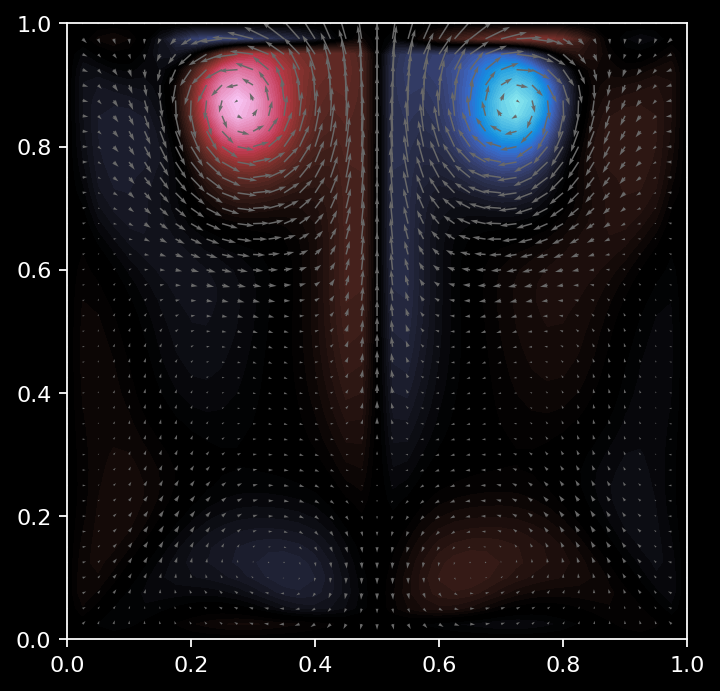

100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


<Figure size 800x800 with 0 Axes>

In [13]:
element_length = DOMAIN_SIZE / (N_POINTS - 1)
scalar_shape = (N_POINTS, N_POINTS)   # 标量场形状
scalar_dof = N_POINTS * N_POINTS      # 自由度总数
vector_shape = (N_POINTS, N_POINTS, 2)  # 向量场形状
vector_dof = N_POINTS * N_POINTS * 2  # 向量场自由度总数

x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

# Using "ij" indexing makes the differential opertors more logical, Take care when plotting.
X, Y = np.meshgrid(x, y, indexing='ij') # 创建网格点 [41, 41]

coordinates = np.concatenate(        # [41, 41, 2]
    (
        X[..., np.newaxis],
        Y[..., np.newaxis],
    ),
    axis=-1
)

def laplace(field):
    diff = np.zeros_like(field)

    diff[1:-1, 1:-1] = (
        (
            field[0:-2, 1:-1]
            +
            field[1:-1, 0:-2]
            -
            4.0 * field[1:-1, 1:-1]
            +
            field[2: , 1:-1]
            +
            field[1:-1, 2:]
        ) / (element_length ** 2)
    )

    return diff

def partial_derivative_x(field):
    diff = np.zeros_like(field)

    diff[1:-1, 1:-1] = (
        (
            field[2:, 1:-1]
            -
            field[0:-2, 1:-1]
        ) / (2.0 * element_length)
    )

    return diff

def partial_derivative_y(field):
    diff = np.zeros_like(field)

    diff[1:-1, 1:-1] = (
        (
            field[1:-1, 2:]
            -
            field[1:-1, 0:-2]
        ) / (2.0 * element_length)
    )

    return diff

def divergence(vector_field):
    divergence_applied = (
        partial_derivative_x(vector_field[..., 0])
        +
        partial_derivative_y(vector_field[..., 1])
    )

    return divergence_applied

def gradient(field):
    gradient_applied = np.concatenate(
        (
            partial_derivative_x(field)[..., np.newaxis],
            partial_derivative_y(field)[..., np.newaxis],
        ),
        axis=-1
    )

    return gradient_applied

def curl_2d(vector_field):
    curl_applied = (
        partial_derivative_x(vector_field[..., 1])
        -
        partial_derivative_y(vector_field[..., 0])
    )

    return curl_applied

def advect(field, vector_field):
    backtraced_positions = np.clip(
        (
            coordinates
            -
            TIME_STEP_LENGTH * vector_field
        ),
        0.0,
        DOMAIN_SIZE
    )

    advected_field = interpolate.interpn(
        points=(x, y),
        values=field,
        xi=backtraced_positions,
    )

    return advected_field

def diffusion_operator(vector_field_flattened):
    vector_field = vector_field_flattened.reshape(vector_shape)

    diffusion_applied = (
        vector_field
        -
        KINEMATIC_VISCOSITY
        *
        TIME_STEP_LENGTH
        *
        laplace(vector_field)
    )

    return diffusion_applied.flatten()

def poisson_operator(field_flattened):
    field = field_flattened.reshape(scalar_shape)

    poisson_applied = laplace(field)

    return poisson_applied.flatten()

plt.style.use('dark_background')
plt.figure(figsize=(5, 5), dpi= 160)



forcing_function_vectorized = np.vectorize(pyfunc=forcing_function, signature="(), (d)->(d)")

velocities_prev = np.zeros(vector_shape)  # 速度场初始化为0

time_current = 0.0
for time_step in tqdm(range(N_TIME_STEPS)):
    time_current += TIME_STEP_LENGTH

    # 1. Apply forces
    forces = forcing_function_vectorized(time_current, coordinates)

    velocities_forces_applied = (
        velocities_prev
        +
        TIME_STEP_LENGTH * forces
    )

    # 2. Nonlinear convection (self-advection)
    velocities_advected = advect(
        field=velocities_forces_applied,
        vector_field=velocities_forces_applied,
    ) # semi Lagrangian advection

    # 3. Diffuse, 需要解一个线性方程组，使用共轭梯度法，使用拉普拉斯算子
    velocities_diffused = splinalg.cg(   # Conjugate Gradient 共轭梯度
        A=splinalg.LinearOperator(
            shape=(vector_dof, vector_dof),
            matvec=diffusion_operator,
        ),
        b=velocities_advected.flatten(),
        maxiter=MAX_ITER_CG,
    )[0].reshape(vector_shape)

    # 4.1 Compute a pressure correction
    pressure = splinalg.cg(
        A=splinalg.LinearOperator(
            shape=(scalar_dof, scalar_dof),
            matvec=poisson_operator,
        ),
        b=divergence(velocities_diffused).flatten(),
        maxiter=MAX_ITER_CG,
    )[0].reshape(scalar_shape)

    # 4.2 Correct the velocities to be incompressible
    velocities_projected = (
        velocities_diffused
        -
        gradient(pressure)
    )

    # 5. Advance to next time step
    velocities_prev = velocities_projected

    # Plot
    curl = curl_2d(velocities_projected)
    plt.contourf(
        X,
        Y,
        curl,
        cmap=cmr.redshift,
        levels=100,
    )
    plt.quiver(
        X,
        Y,
        velocities_projected[..., 0],
        velocities_projected[..., 1],
        color="dimgray",
    )
    # plt.draw()
    # plt.pause(0.0001)
    clear_output(wait=True)         # 关键：原地刷新
    display(plt.gcf())              # 把当前图再丢出去
    plt.clf()



## 公式步骤推导

### 关于步骤三，我们使用隐式方法求解扩散方程

在动量方程$\underbrace{\frac{\partial \mathbf{u}}{\partial t}}_{\text{I. 非定常项}} + \underbrace{(\mathbf{u} \cdot \nabla) \mathbf{u}}_{\text{II. 对流项}} = \underbrace{- \frac{1}{\rho} \nabla p}_{\text{III. 压力梯度项}} + \underbrace{\nu \nabla^2 \mathbf{u}}_{\text{IV. 粘性项}} + \underbrace{\mathbf{f}}_{\text{V. 体力项}}$ 中

第IV项就是**粘性扩散项**，数学上形式与热传导方程类似

1. 算子分裂

Stable Fluids算法采用**算子分裂**，将复杂的NS方程分解为4个ke独立求解的子问题。

在扩散这一步，我们只关注**时间变化** 和 **扩散**这两项， 也就是第I项和第IV项：

$$ \frac{\partial \mathbf{u}}{\partial t} \approx \nu\nabla^{2}\mathbf{u} $$

2. 时间离散化

我们使用有限差分来近似时间导数 $\frac{\partial \mathbf{u}}{\partial t}$

$$\frac{\partial \mathbf{u}}{\partial t} \approx \frac{\mathbf{u}^{t+\Delta t} - \mathbf{u}^{t}}{\Delta t}$$

带入扩散方程：

$$\frac{\mathbf{u}^{t+\Delta t} - \mathbf{u}^{t}}{\Delta t} = \nu\nabla^{2}\mathbf{u}$$

我们的目标是求解$\mathbf{u}^{t+\Delta t}$, 那么这个方程中$\mathbf{u}$中如何选择就表现了**显示方法**和**隐式方法**的区别了。其中Stable Fluids采用了**隐式方法**

- **显式方法**

将$\mathbf{u}$选择为 $\mathbf{u}^{t}$, 也就是把$\mathbf{u}$选择为 $\mathbf{w}_2$,公式就变成了：

$$\frac{\mathbf{u}^{t+\Delta t} - \mathbf{u}^{t}}{\Delta t} = \nu\nabla^{2}\mathbf{u}^{t}$$

使用 Stable Fluids 的符号：$\mathbf{w}_3 = \mathbf{u}^{t+\Delta t}$ (未知)，$\mathbf{w}_2 = \mathbf{u}^{t}$ (已知)。

$$\frac{\mathbf{w}_3 - \mathbf{w}_2}{\Delta t} = \nu\nabla^{2}\mathbf{w}_2$$

化简可得： $$\mathbf{w}_3 = (I + \nu \Delta t \nabla^{2})\mathbf{w}_2$$

这个形式是直接可计算的！不需要求解线性方程组

缺点： 显式格式会受制于CFL 条件（Courant–Friedrichs–Lewy condition），要求 $\Delta t < \frac{1}{2}\Delta x^2 / \nu$。当粘度 $\nu$ 较大或网格 $\Delta x$ 较小时，$\Delta t$ 必须非常小才能保证数值稳定，这在计算机图形学中通常是不可接受的。



- **隐式方法**

将$\mathbf{u}$选择为 $\mathbf{u}^{t+\Delta t}$, 也就是把$\mathbf{u}$选择为 $\mathbf{w}_3$,公式就变成了：

$$\frac{\mathbf{u}^{t+\Delta t} - \mathbf{u}^{t}}{\Delta t} = \nu\nabla^{2}\mathbf{u}^{t+\Delta t}$$

使用 Stable Fluids 的符号：$\mathbf{w}_3 = \mathbf{u}^{t+\Delta t}$ (未知)，$\mathbf{w}_2 = \mathbf{u}^{t}$ (已知)。

$$\frac{\mathbf{w}_3 - \mathbf{w}_2}{\Delta t} = \nu\nabla^{2}\mathbf{w}_3$$

化简可得：$$(I - \nu \Delta t \nabla^{2})\mathbf{w}_3 = \mathbf{w}_2$$

这个最终形式 $(I - \nu \Delta t \nabla^{2})\mathbf{w}_3 = \mathbf{w}_2$ 是一个标准的线性方程组 $\mathbf{A}\mathbf{x} = \mathbf{b}$
- 待求解向量 $\mathbf{x}$： $\mathbf{w}_3$ (扩散后的速度场)
- 右侧向量 $\mathbf{b}$： $\mathbf{w}_2$ (扩散前的速度场)
- 系数矩阵 $\mathbf{A}$： $(I - \nu \Delta t \nabla^{2})$

Stable Fluids 采用共轭梯度法求解这个线性方程组。也就是scipy中的`splinalg.cg`函数。

### 关于步骤4.1 计算压力修正，柏松方程部分

Stable Fluids 论文给出的求解方式就是：$\nabla^2 p = \nabla \cdot \mathbf{w}_3$

在 Stable Fluids 算法中，投射 (Projection) 步是最后一个步骤。在此之前，我们已经完成了：
- 施加外力
- 对流 (Advection)
- 粘性扩散 (Diffusion)

这三个步骤产生了一个中间速度场 $\mathbf{w}_3$。

由于 $\mathbf{w}_3$ 在计算过程中没有考虑压力校正，它很可能不满足不可压缩条件，即 $\nabla \cdot \mathbf{w}_3 \ne 0$。

我们的目标是找到一个最终速度场 $\mathbf{w}_4$，它必须是不可压缩的：$$\nabla \cdot \mathbf{w}_4 = 0$$


3. 赫姆霍兹-霍奇分解 (Helmholtz-Hodge Decomposition)这是数学上的核心。

赫姆霍兹-霍奇定理指出，任何一个向量场 $\mathbf{w}$ 都可以唯一地分解为两部分之和：$$\mathbf{w} = \mathbf{w}_{\text{incompressible}} + \nabla q$$

其中：

$\mathbf{w}_{\text{incompressible}}$ 是无散度 (Divergence-Free) 的向量场（即 $\nabla \cdot \mathbf{w}_{\text{incompressible}} = 0$）。

$\nabla q$ 是无旋度 (Curl-Free) 的向量场，被称为梯度场 (Gradient Field)，它来自一个标量势函数 $q$。

在流体模拟中，我们希望将不满足不可压缩性的中间速度场 $\mathbf{w}_3$ 分解为：$$\mathbf{w}_3 = \mathbf{w}_4 + \nabla q$$

其中：

- $\mathbf{w}_4$ 就是我们想要的最终（可压缩）速度场。
- $\nabla q$ 就是由压力 $p$ 产生的校正梯度场。

物理对应关系： 压力 $p$ 驱动的校正项 $-\frac{1}{\rho}\nabla p$ 正好与数学上的梯度场 $\nabla q$ 对应。

我们可以简单地让 $q \propto p$（$q$ 通常被称为压力校正或标量势）。


4. 从分解到泊松方程的推导

我们希望通过减去梯度场 $\nabla q$ 来得到最终的无散度速度场 $\mathbf{w}_4$：

$$\mathbf{w}_4 = \mathbf{w}_3 - \nabla q$$

为了找到 $q$，我们利用不可压缩条件：

1. 对 $\mathbf{w}_4 = \mathbf{w}_3 - \nabla q$ 两边取散度 (Divergence) 算子 $\nabla \cdot (\cdot)$：

$$\nabla \cdot \mathbf{w}_4 = \nabla \cdot (\mathbf{w}_3 - \nabla q)$$

2. 根据 $\mathbf{w}_4$ 的定义，其散度必须为零：

$$0 = \nabla \cdot \mathbf{w}_3 - \nabla \cdot (\nabla q)$$

3. 根据向量微积分，两个梯度场连续作用 $\nabla \cdot (\nabla q)$ 等于拉普拉斯算子 $\nabla^2 q$：

$$0 = \nabla \cdot \mathbf{w}_3 - \nabla^2 q$$

4. 整理后，我们就得到了著名的**泊松方程 (Poisson Equation)**：

$$\nabla^2 q = \nabla \cdot \mathbf{w}_3$$


这就是一个线性方程了，我们可以用共轭梯度法求解。其中A是拉普拉斯算子，b是扩散后的速度场$\mathbf{w}_3$的散度场。

## 关于共轭梯度法

共轭梯度法是一种**迭代求解器 (Iterative Solver)**，用于求解以下形式的线性方程组：

$$\mathbf{A}\mathbf{x} = \mathbf{b}$$

其中：
- $\mathbf{A}$ 是一个已知的系数矩阵。
- $\mathbf{b}$ 是一个已知的右侧项向量。
- $\mathbf{x}$ 是我们要求的解向量（例如，扩散后的速度 $\mathbf{w}_3$ 或压力场 $q$）。

前提条件： CG 法只能用于求解 $\mathbf{A}$ 是对称正定 (Symmetric Positive Definite, SPD) 矩阵的方程组。


**共轭梯度法可以通过算子求解**

CG 方法在大型科学计算中被称为**矩阵无关 (Matrix-Free)** 方法

CG 算法在整个迭代过程中，唯一需要使用矩阵 $\mathbf{A}$ 的操作是计算矩阵-向量乘积：
$$\mathbf{y} = \mathbf{A}\mathbf{p}$$
算法流程中没有涉及到矩阵 $\mathbf{A}$ 的显式存储或反演（即计算 $\mathbf{A}^{-1}$）。

对于**柏松方程**来说：$\nabla^2 q = \nabla \cdot \mathbf{w}_3$

这里面就是方程组Ax = b, A就是拉普拉斯算子，b就是扩散后的速度场$\mathbf{w}_3$的散度场。


这个矩阵 $\mathbf{A}$ 是客观存在的。 它是一个巨大的、稀疏的矩阵，定义了网格点上的值如何通过有限差分公式相互连接。

对于向量 $\mathbf{x}$ 中的任何一个元素 $x_k$（对应 $p_{i, j}$），矩阵 $\mathbf{A}$ 的第 $k$ 行将有 5 个非零元素：
- 中心点 $p_{i, j}$ 对应的列：值是 $-\frac{4}{\Delta x^2}$。
- 四个邻居 $p_{i \pm 1, j}, p_{i, j \pm 1}$ 对应的列：值是 $\frac{1}{\Delta x^2}$。
- 其他所有元素都是 $0$。

显式存储几乎是不可能的。

**CG 方法的精髓所在是：它实现了“矩阵无关”求解：**

我们求解 $\mathbf{A}\mathbf{x} = \mathbf{b}$ 时，CG 算法在每一步迭代中，只需要知道如何计算矩阵乘积 $\mathbf{y} = \mathbf{A}\mathbf{p}$。

3. Scipy 中 CG 方法的使用

1. 定义算子函数 (matvec)您定义了两个算子函数：

poisson_operator(field_flattened): 实现 $\mathbf{A}_{\text{Poisson}} \mathbf{x} = \nabla^2 \mathbf{x}$。

2. 创建线性算子 (LinearOperator)

```python
A_poisson = splinalg.LinearOperator(
    shape=(scalar_dof, scalar_dof), # 告诉求解器矩阵的维度
    matvec=poisson_operator,       # 传入实现 A * x 运算的函数
)
```

3. 调用共轭梯度法 (cg) splinalg.cg()

```python
# 求解 A_poisson * pressure = divergence(velocities_diffused)
pressure_solution = splinalg.cg(
    A=A_poisson,
    b=divergence(velocities_diffused).flatten(), # b 向量
    maxiter=MAX_ITER_CG, # 最大迭代次数
)

# pressure_solution[0] 是解向量 x
pressure = pressure_solution[0].reshape(scalar_shape) # 将解向量 x 转换回二维数组
```
